## Brief Description
This notebook contains the code for our second approach in creating and training our AI model. The structure of our model changes to LSTM and dense layers. The model was trained on data from just one person, leading to overfitting. The results were adequate, but could be improved upon.

Also included is statistics generation and live testing.

# Preprocess and Load Data

In [1]:
from ADUtils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

## Load Data

In [2]:
# Whether you already have data stored in a npy file
load_from_npy = False

In [3]:
label_map = {label:num for num, label in enumerate(actions)}

In [4]:
# This loads data if it is not already stored in a npy file. 
if not load_from_npy:

    sequences, labels = [], []
    skip_sequence = False
    for action in actions:
        action_path = os.path.join(DATA_PATH, action)
        if not os.path.exists(action_path):
            continue
        for sequence in np.array(os.listdir(action_path)).astype(int):
            window = []
            skip_sequence = False
            for frame_num in range(sequence_length):
                sequence_path = os.path.join(action_path, str(sequence))
                # 1. make sure path exists
                if not os.path.exists(sequence_path):
                    print("1")
                    skip_sequence = True
                    break
                # 2. make sure none are empty
                try:
                    res = np.load(os.path.join(sequence_path, "{}.npy".format(frame_num)))
                    window.append(res)
                except:
                    print(f"Cannot read {sequence_path} number {frame_num}")
                    print("2")
                    skip_sequence = True
                    break
            if not skip_sequence:
                # 3. make sure there is at least 30 frames
                if len(window) == 30:
                    sequences.append(window)
                    labels.append(label_map[action])
                    continue
                print("3")

## Description of Input Data

The tuple from the next command shows the dimension of our data. The details of the data is as follows. 

The first tuple displays the number of samples we collected. We collected samples for seven actions: 'raise_hand', 'thumbs_up', 'thumbs_down', 'cheer', 'cross_arms', 'clap', 'neutral'. For each of these actions, we captured variations of them to ensure we're covering variability for each action. This list describes the variation and number of samples for each:  
- raise_hand: 30 left hand only (15 hand on screen and 15 off), 30 right hand only (15 on screen and 15 off)
- thumbs_up: 30 left hand only, 30 right hand only, 30 both hands
- thumbs_down: 30 left hand only, 30 right hand only, 30 both hands 
- cheer: 30 hands below head, 30 hands above head 
- cross_arms: 30 no hands, 30 right hand only, 30 left hand only, 30 both hands
- clap: 30 right hand over left, 30 left hand over right, 30 both hands vertical to the screen
- neutral: 30 no hands 

The second element in the tuple shows that each sample has 30 frames. 

The last element in the tuple shows the number of data points per frame. These were extracted from the MediaPipe Holistic model. The features we are using include 33 pose landmarks (each of which have coordinates x, y, z, and visibility) and 21 hand landmarks (each have coordinates x, y, z). Moreover, we are collecing landmarks for both the left and the right hands. In total this is 258 coordinates (33 * 4 + 21 * 3 + 21 * 3). 

In [5]:
print(np.array(sequences).shape)
# number of samples, number of frames per sample, number of data points per frame

(270, 30, 258)


## Splitting Data

In [6]:
if not load_from_npy:
    X = np.array(sequences)
else:
    X = np.load(os.path.join(DATA_PATH, 'action_detect_X.npy'))

In [7]:
if not load_from_npy:
    y = to_categorical(labels).astype(int)
else:
    y = np.load(os.path.join(DATA_PATH, 'action_detect_y.npy'))

In [8]:
save_to_numpy = False
if save_to_numpy:
    np.save(os.path.join(DATA_PATH, 'action_detect_X.npy'), X)
    np.save(os.path.join(DATA_PATH, 'action_detect_y.npy'), y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# Build and Train Model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

In [11]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

## Chosen Architecture

We used multiple LSTM layers stacked together to allow the model to learn higher-level temporal representations. Each layer potentially captures different aspects of temporal dependencies in the data. The ReLU activation function in the dense layers introduces non-linearity into the model, allowing it to learn more complex patterns in the data. The final dense layer uses a softmax activation for classification. We found that this amount of layers allowed the model to learn complex relationships in the data without overfitting. 

In [12]:
model = Sequential()
# model.add(Input(shape=(30,258)))
model.add(Input(shape=X_train.shape[-2:]))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=100, callbacks=[tb_callback])

In [20]:
save_model = False
if save_model:
    model.save('action.keras')

## Validate Initial Model with 5-Fold-Cross-Validation

We used 5-fold-cross-validation to check if our model was overfitting. 

In [17]:
from sklearn.model_selection import KFold

In [18]:
sequences = np.array(sequences)  
labels = np.array(labels)  

# Split the data
X_train_val, X_test, y_train_val, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # Validation is 20% of the original

if len(y_train.shape) == 1:  
    y_train = to_categorical(y_train, num_classes=actions.shape[0])
    y_val = to_categorical(y_val, num_classes=actions.shape[0])

In [19]:
y_train_val = to_categorical(y_train_val, num_classes=np.unique(y_train_val).size)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracies = []

for train_index, val_index in kf.split(X_train_val):
    # Split data
    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    y_train, y_val = y_train_val[train_index], y_train_val[val_index]

    model = Sequential()
    # model.add(Input(shape=(30,258)))
    model.add(Input(shape=X_train.shape[-2:]))
    model.add(LSTM(64, return_sequences=True, activation='relu'))
    model.add(LSTM(128, return_sequences=True, activation='relu'))
    model.add(LSTM(64, return_sequences=False, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(actions.shape[0], activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train model
    model.fit(X_train, y_train, epochs=100, verbose=0)
    
    # Evaluate model
    scores = model.evaluate(X_val, y_val, verbose=0)
    print(f"Score for fold {fold_no}: Accuracy of {scores[1]*100:.2f}%")
    accuracies.append(scores[1] * 100)
    fold_no += 1

average_score = np.mean(accuracies)
print(f"Average Score: {average_score:.2f}%")

Score for fold 1: Accuracy of 70.45%
Score for fold 2: Accuracy of 95.35%
Score for fold 3: Accuracy of 90.70%
Score for fold 4: Accuracy of 86.05%
Score for fold 5: Accuracy of 86.05%
Average Score: 85.72%


# Statistics

In [21]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report, f1_score

In [22]:
y_prob = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


In [24]:
# Uncomment this if 5-fold-cross-validation was used
# y_true = y_test.tolist() 
# y_pred = np.argmax(y_prob, axis=1).tolist()

In [25]:
# Comment this out if 5-fold-cross-validation was used
y_true = np.argmax(y_test, axis=1).tolist()
y_pred = np.argmax(y_prob, axis=1).tolist()

In [26]:
accuracy_score(y_true, y_pred)

0.8333333333333334

In [27]:
classification_report(y_true, y_pred)

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00         7\n           1       0.38      0.75      0.50         4\n           2       0.80      0.67      0.73         6\n           3       0.73      1.00      0.84         8\n           4       1.00      0.78      0.88         9\n           5       1.00      0.71      0.83        14\n           6       1.00      1.00      1.00         6\n\n    accuracy                           0.83        54\n   macro avg       0.84      0.84      0.83        54\nweighted avg       0.89      0.83      0.85        54\n'

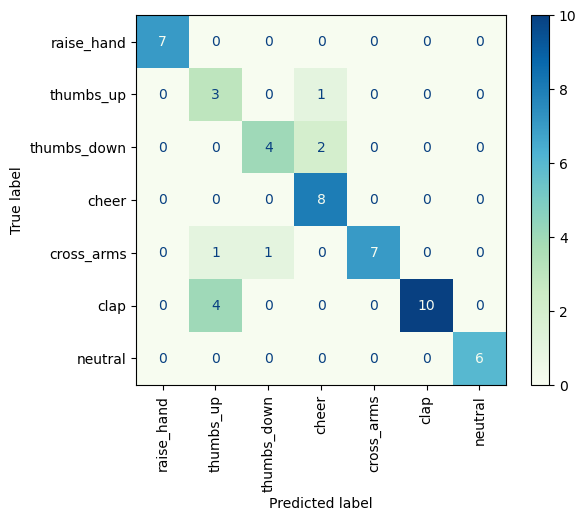

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=actions)
disp.plot(cmap='GnBu', xticks_rotation='vertical')
plt.show()

# Test in Real Time

In [ ]:
from tensorflow.keras.models import load_model
if save_model:
    model = load_model('action.keras')

In [ ]:
# change the colors
colors = [(245,117,16), (117,245,16), (16,117,245), (245,117,16), (117,245,16), (16,117,245), (245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
sequence = []
threshold = 0.5

# if you want to use video as testing
# video = '../data/test/questioning/cross_arms3.mp4'
# cap = cv2.VideoCapture(video)

# if you want a bigger video at the cost of performance
# cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
# cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
# cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        word = ''
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0), verbose=0)[0]
#             print(actions[np.argmax(res)])
            
            word = actions[np.argmax(res)]
                
            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
        
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)

        cv2.putText(image, word, (3,30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# Self Label Video Testing

In [29]:
pred = ['cross_arms', 'clap', 'raise_hand', 'thumbs_down', 'thumbs_down', 'cross_arms', 'raise_hand', 'raise_hand', 'clap', 'thumbs_up', 'clap', 'raise_hand', 'thumbs_up', 'cheer', 'cross_arms', 'cross_arms', 'neutral', 'cross_arms', 'cross_arms', 'cross_arms']
act = ['clap', 'clap', 'clap', 'thumbs_up', 'thumbs_up', 'thumbs_up', 'raise_hand', 'raise_hand', 'raise_hand', 'cheer', 'cheer', 'cheer', 'thumbs_down', 'thumbs_down', 'thumbs_down', 'neutral', 'neutral', 'cross_arms', 'cross_arms', 'cross_arms']

accuracy_score(act, pred)

0.35

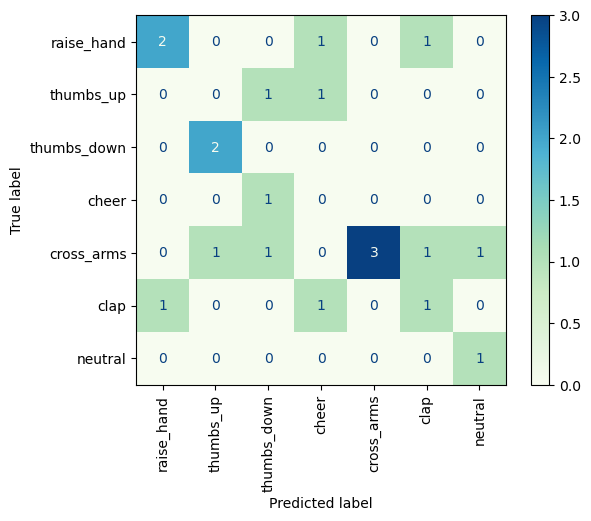

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 

cm = confusion_matrix([label_map[item] for item in pred], [label_map[item] for item in act])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=actions)
disp.plot(cmap='GnBu', xticks_rotation='vertical')
plt.show()